# Clock-Packing of Spheres

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/optim/Close_Packing.ipynb)

This example optimizes sphere positions in order to find the maximally frustrated state, i.e. fill a limited space with as little overlap as possible.

In [1]:
# %pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.

For a given number of spheres, we first define the domain `size` so that 5% more area is available than the spheres take up.
Then we initialize the spheres at random points inside the periodic domain.

<Figure size 432x216 with 2 Axes>

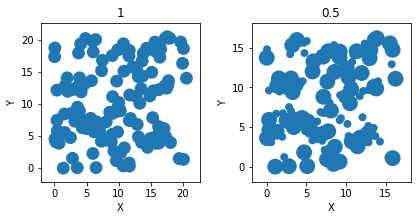

In [2]:
R = wrap([1]*64 + [vec(batch('d'), 1, .5)]*64, instance('spheres'))
size = (math.sum(Sphere(vec(x=0, y=0), R).volume, 'spheres') * 1.05) ** .5
x0 = math.random_uniform(instance(R), channel(vector='x,y'), high=size)
plot(Sphere(x0, R), size=(6, 3))

Next, we define the loss function to be minimized.
We penalize spheres whose distance is shorter than their combined radii.

In [4]:
def loss(x: Tensor, boundary=PERIODIC):
    dx = boundary.shortest_distance(x, rename_dims(x, 'spheres', 'o'), size)
    dr = math.vec_length(dx, eps=1e-8) / (R + rename_dims(R, 'spheres', 'o'))
    return math.l2_loss(math.where((dr < 2e-4) | (dr > 1), 0, 1 - dr))

We can not optimize this system using an optimizer of our choice. Here we use SciPy's `L-BFGS-B` optimizer.

<Figure size 432x216 with 2 Axes>

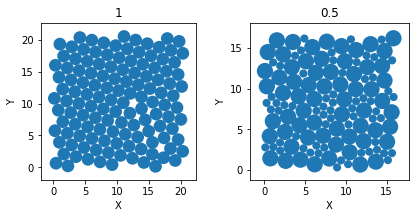

In [5]:
x_packed = minimize(loss, Solve('L-BFGS-B', x0=x0)) % size
plot(Sphere(x_packed, R), size=(6, 3))

Φ<sub>Flow</sub> also allows us to record the intermediate states of the optimization.
We can use these to visualize the process.

In [6]:
with math.SolveTape(record_trajectories=True) as solves:
    minimize(loss, Solve('L-BFGS-B', x0=x0))
x_trj = solves[0].x % size

In [10]:
plot(Sphere(x_trj, R), size=(8, 4), animate='trajectory', frame_time=40)